# Group Project Report: 
# Evaluation of K-Nearest Neighbours Classification Prediction on Algerian Forest Fire based on Fine Fuel Moisture Code (FFMC) and Drought Code (DC)
### Group members: Cassie Zhong, Khoi Nguyen, Helen He, Donna Li
*As a policy of our group contract, we would like to indicate that Donna has not participated in any of our project discussions, and she has not contributed at all to this project report.

## Introduction

### Background information: 
While forest fires can be incredibly destructive to the environment, they are also a natural part of forest life cycles. To mitigate risks and better prepare local areas, being able to predict if a forest fire will occur at a given time would be very beneficial. 

Researchers have collected data on forest fires in two regions of Algeria, Bejaia and Sidi Bel-Abbes, from June 2012 to September 2012 (https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++). This dataset includes 244 total observations and 10 variables: 
- Temperature, in Celsius degrees
- Relative humidity, in %
- Wind speed, in km/h
- Rain, in mm
- Fine Fuel Moisture Code (FFMC)
- Duff Moisture Code (DMC)
- Drought Code (DC)
- Initial Spread Index (ISI)
- Buildup Index (BUI)
- Fire Weather Index (FWI)

Six of these variables (FFMC, DMC, DC, ISI, BUI and FWI) are components of the Forest Fire Weather Index System (https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi), indicating relative potential for wildfires, and are calculated from the remaining four variables (temperature, relative humidity, wind speed and rain).

### Figure 1: The Fire Weather Index (FWI) structure
<img src='https://cwfis.cfs.nrcan.gc.ca/images/fwi_structure.gif' width='400'>

Source: https://cwfis.cfs.nrcan.gc.ca/images/fwi_structure.gif

Using this dataset, we will attempt to perform K-nearest neighbours classification to predict from a new set of measurements if a forest fire will occur, and we will evaluate the accuracy of such predictions.

## Question: How accurate is the prediction of whether a fire will occur based on FFMC and DC using K-NN Classification?


## The big picture:
In order to evaluate the accuracy for our prediction, we have divided the work into two parts: the first part focuses on how the dataset is cleaned up and the second part focused on how the model training and evaluation is performed. By employing cross-validation, we can find the k value with the highest accuracy; then we use knn classification model to make predictions on the testing dataset to evaluate the accuracy.

In [40]:
###
#   Run this cell to install GGally package
###

install.packages("GGally")

Warning message in install.packages("GGally"):
“installation of package ‘GGally’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [41]:
###
#   Load necessary packages
###

library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(tidyr)
library(GGally)
options(repr.matrix.max.rows = 6)

In [42]:
###
#   Set seed to ensure reproducible results
###

set.seed(9999)

## Part 1: Preliminary exploratory data analysis

In [43]:
###
#   Step 1: Reading the dataset into R
###
dataset_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

# Read dataset of Bajaia region and change Classes column type to fct
bajaia_data_all <- read_csv(dataset_url, skip = 1, n_max = 122) %>%
    mutate(Classes = as.factor(Classes))

# Read first 43 rows of dataset of Sidi-Bel Abbes region and change Classes column type to fct
sidi_data_1 <- read_csv(dataset_url, skip = 126, n_max = 43) %>%
    mutate(Classes = as.factor(Classes))

# Read remaining rows of dataset of Sidi-Bel Abbes region and change Classes column type to fct
sidi_data_2_colnames <- colnames(sidi_data_1)
sidi_data_2 <- read_csv(dataset_url, skip = 171, col_names = sidi_data_2_colnames) %>%
    mutate(Classes = as.factor(Classes))

# Concatenate the Sidi-Bel Abbes data frames
sidi_data_all <- rbind(sidi_data_1, sidi_data_2)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),

### Explanation for Step 1
The original dataset had one row with missing values (171th row), which was within the Sidi-Bel section of the dataset, so we had to fix this issue before cleaning the data. When we read the dataset into R, we separate the two regions (Bajaia and Sidi-Bel) first, because Bajaia data was not affected and we could directly read Bajaia data into R without any splitting. Then, we discarded the 171th row in the Sidi-Bel data by splitting into two parts and then recombining them.

In [44]:
###
#   Step 2: Dataset Cleaning & Wrangling
###

# Bind new Region column to each data frame
bajaia_region <- "Bajaia"
sidi_region <- "Sidi-Bel Abbes"
bajaia_data_all["Region"] <- bajaia_region
sidi_data_all["Region"] <- sidi_region


# Combine Bajaia and Sidi-Bel Abbes data frames
fire_data <- rbind(bajaia_data_all, sidi_data_all)
fire_data

# Split data into training and testing sets
fire_split <- initial_split(fire_data, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bajaia
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bajaia
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bajaia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire,Sidi-Bel Abbes
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,Sidi-Bel Abbes
30,09,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire,Sidi-Bel Abbes


Table 1: Preview of the entire dataset

### Explanation for Step 2
In this step, we combined the two regions into one entire dataset again, but this time the problematic row has been discarded. Then we split the dataset into training and testing by a proportion of 75%. We chose this proportion because the entire dataset was not relatively large (with 243 observations), so we would like to increase the accuracy of the model by having more observations in the training dataset.

In [45]:
###
#   Step 3: Summarize data from training dataset
###

# Get number of observations for each Classes in training dataset
fire_train_yes <- fire_train %>%
    filter(Classes == "fire") %>%
    nrow()
fire_train_no <- fire_train %>%
    filter(Classes == "not fire") %>%
    nrow()
observations_per_class <- tibble(classes = c("fire", "not fire"), 
                                 observations = c(fire_train_yes, fire_train_no))
observations_per_class

classes,observations
<chr>,<int>
fire,103
not fire,80


Table 2: A summary of observations from each class in the training set

### Explanation for Step 3
We would like to know whether the observations in the training dataset was biased or not (whether there were too many "fire" cases, or too many "not fire" cases) to make sure that the predictions made by the model is not simply "guessing" based on the majority. We counted the number of observations for each outcome, and the number of observations for "fire" and "not fire" is 103 vs 80 respectively, which is not very close! So we need to perform upsampling to mitigate this issue (the upsampling is done in a later step).

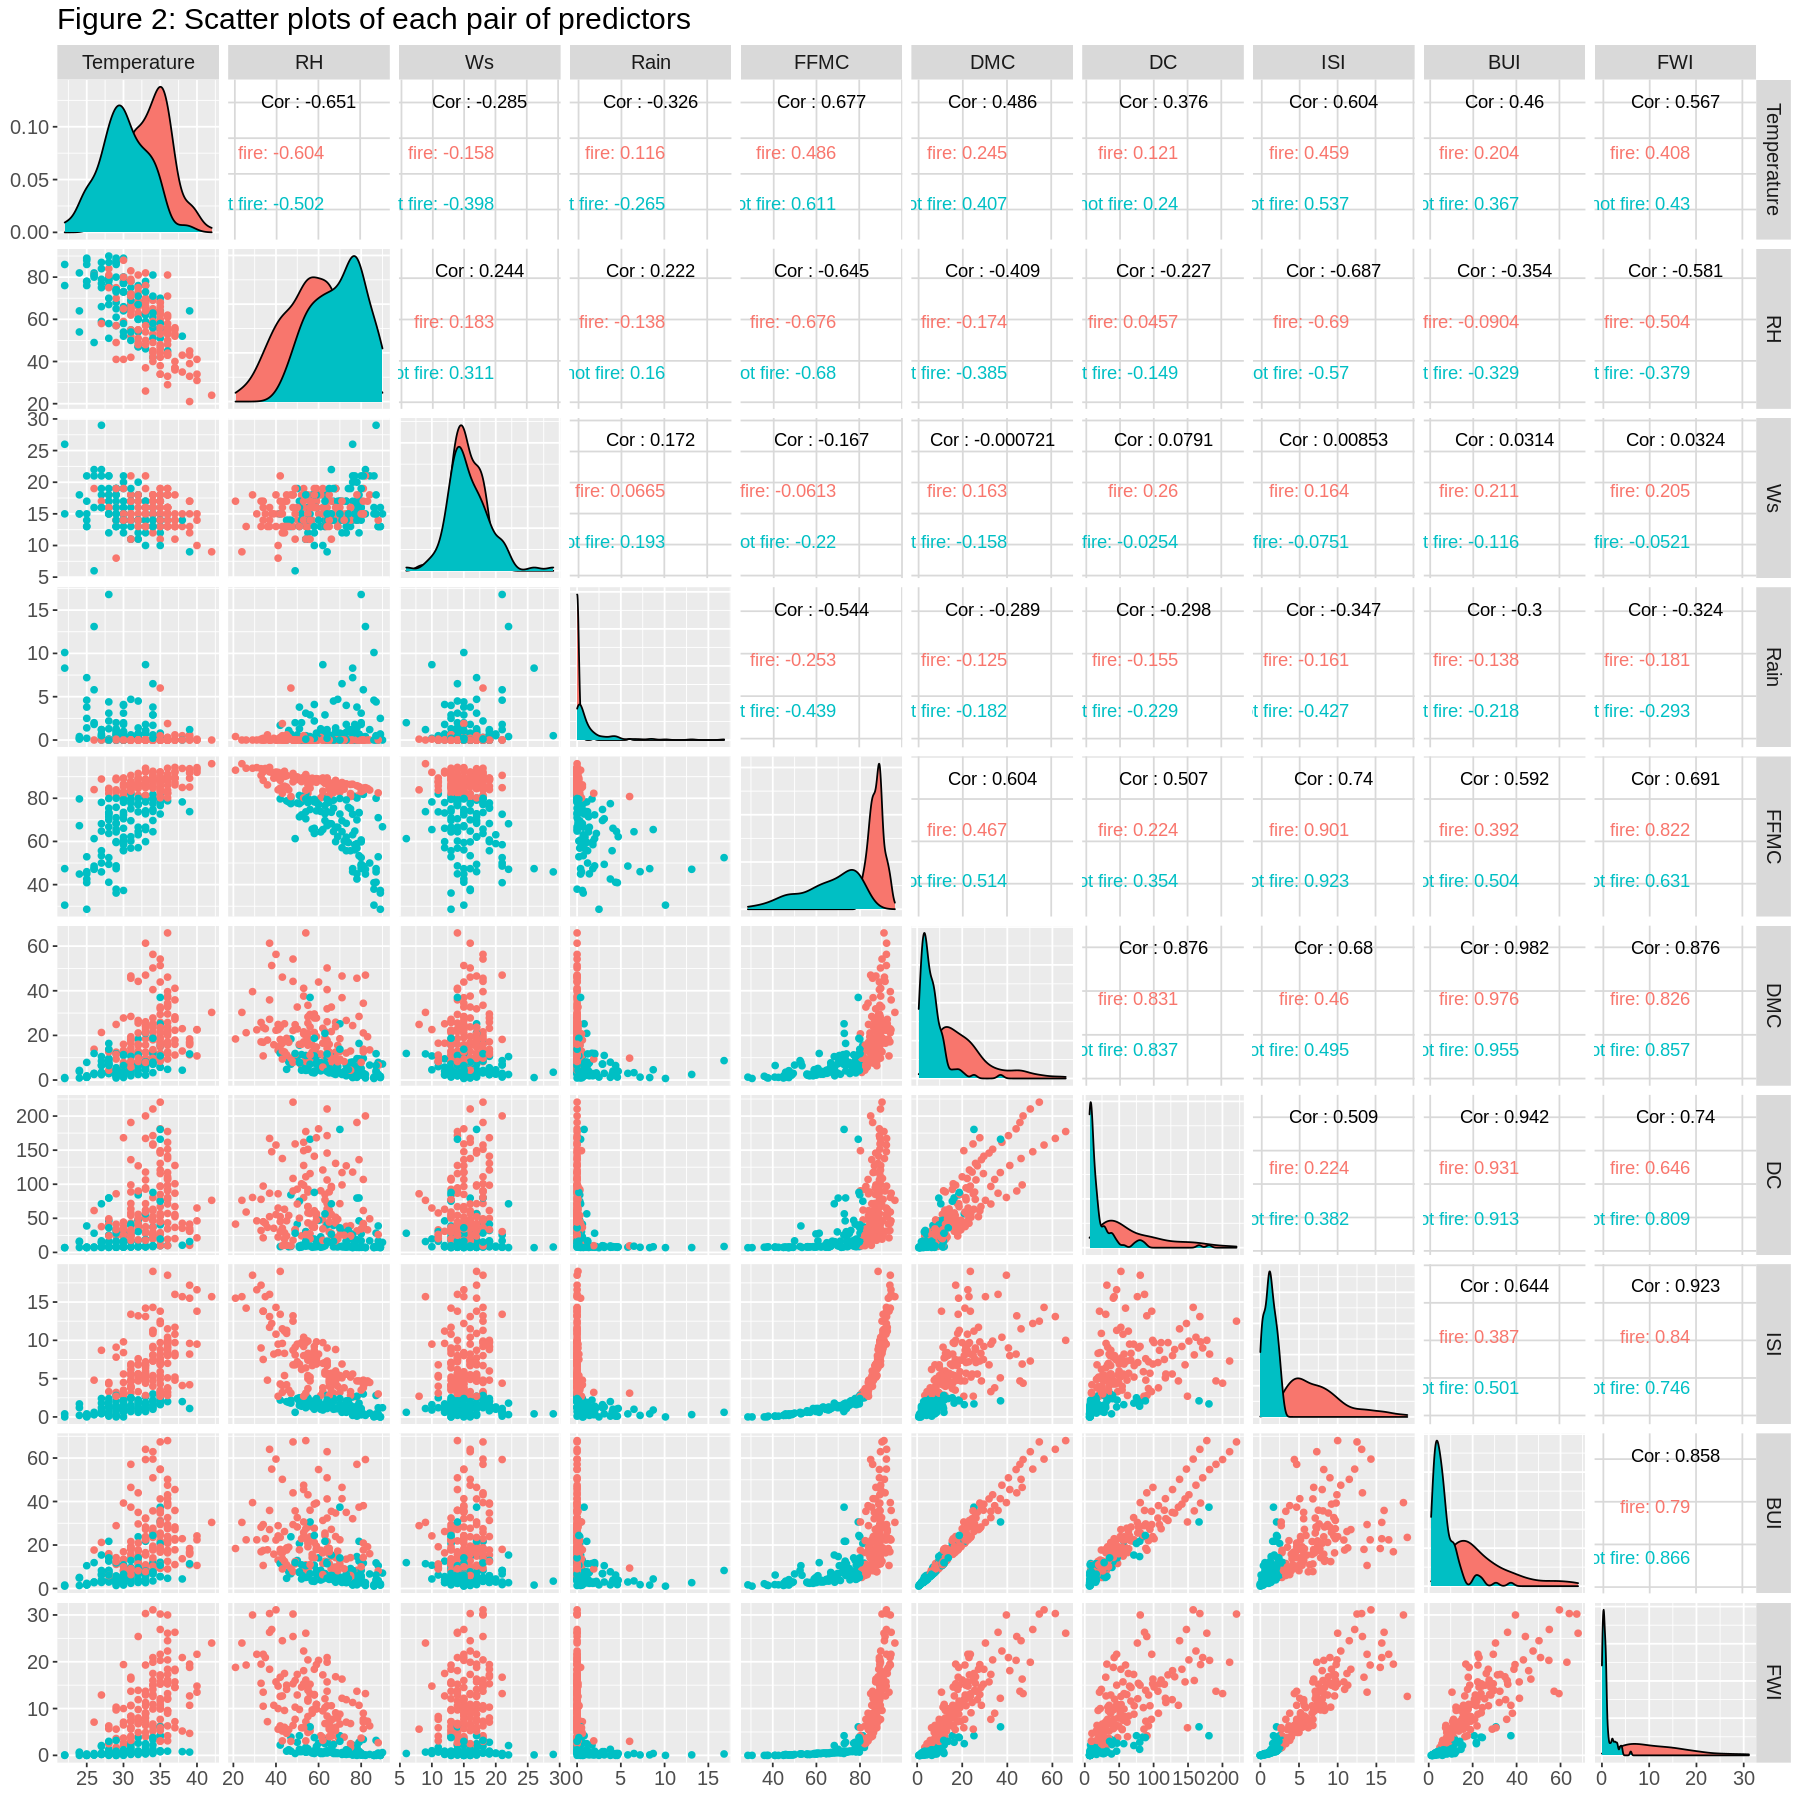

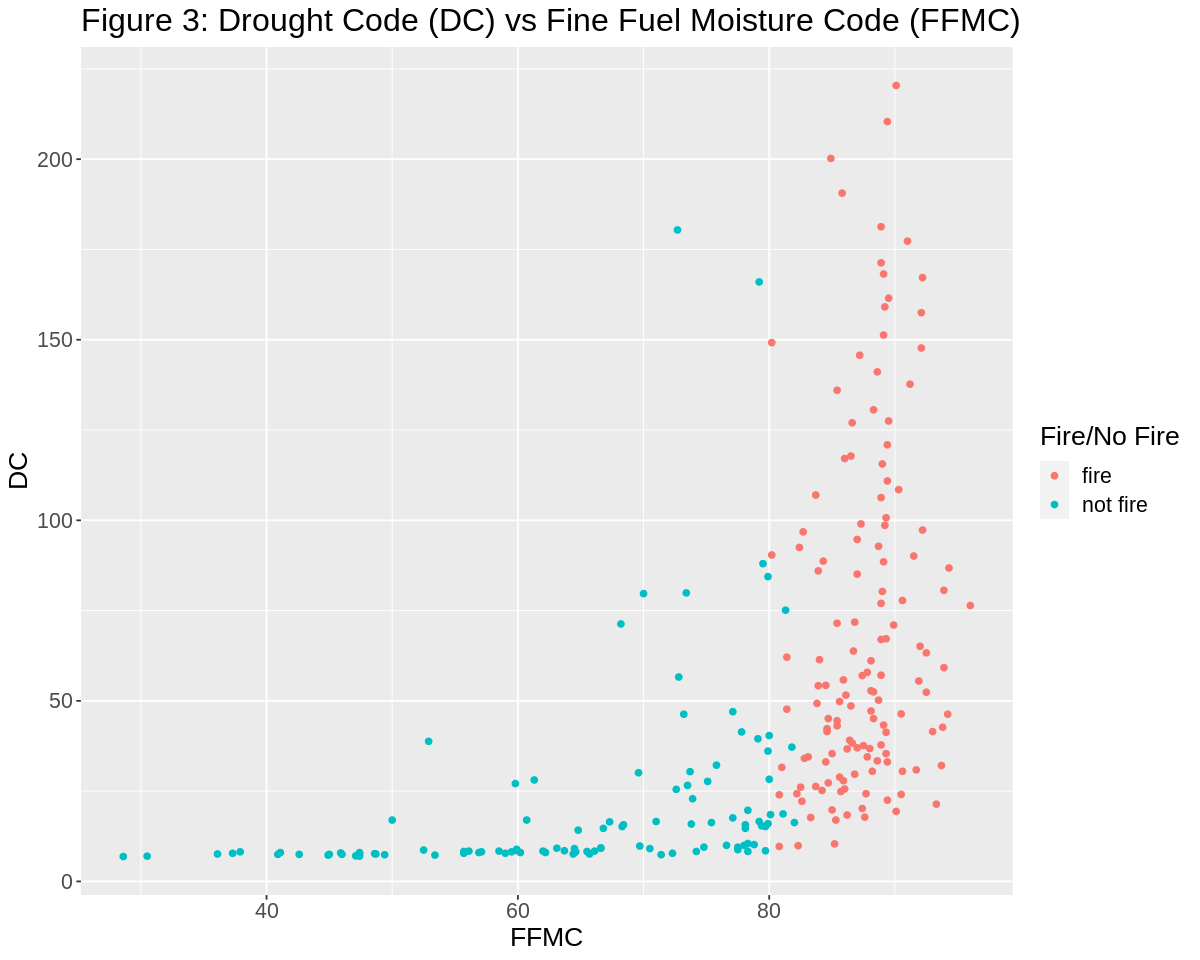

In [46]:
###
#   Step 4: Visualize data from training dataset
###

# Plot each variables against each other
options(repr.plot.height = 15, repr.plot.width = 15)
variables_all_plot <- ggpairs(fire_data, columns = 4:13, aes(color = Classes)) + 
                    ggtitle("Figure 2: Scatter plots of each pair of predictors") +
                    theme(text = element_text(size = 15))
variables_all_plot

# Create a scatterplot of FFMC vs DC
options(repr.plot.height = 8, repr.plot.width = 10)
ffmc_dc_plot <- ggplot (fire_data, aes(x = FFMC, y = DC, color = Classes)) +
                    geom_point() +
                    labs(x = "FFMC", y = "DC", color = "Fire/No Fire") +
                    ggtitle("Figure 3: Drought Code (DC) vs Fine Fuel Moisture Code (FFMC)") +
                    theme(text = element_text(size = 16))
ffmc_dc_plot

### Explanation for Step 4
We have chosen 2 predictors, FFMC and DC, out of the ten predictors in the original dataset. Firstly, this is because we would like to create a simpler visualization of the prediction map (see Figure 5), and the visualization would be very complicated with 3 or more predictors. Secondly, based on Figure 1 which shows the FWI structure, we can see that the four measured predictors (temperature, relative humidity, rain, and wind speed) are integrated into more advanced predictors in different ways. So we use a ggpair plot to demonstrate how each pairs of predictors are distributed when predicting the outcome (Figure 2); we choose FFMC and DC from the second level of integration (Fuel moisture Codes) because there are less overlap between the predictors compared to other pairs.

## Part 2: Data Analysis

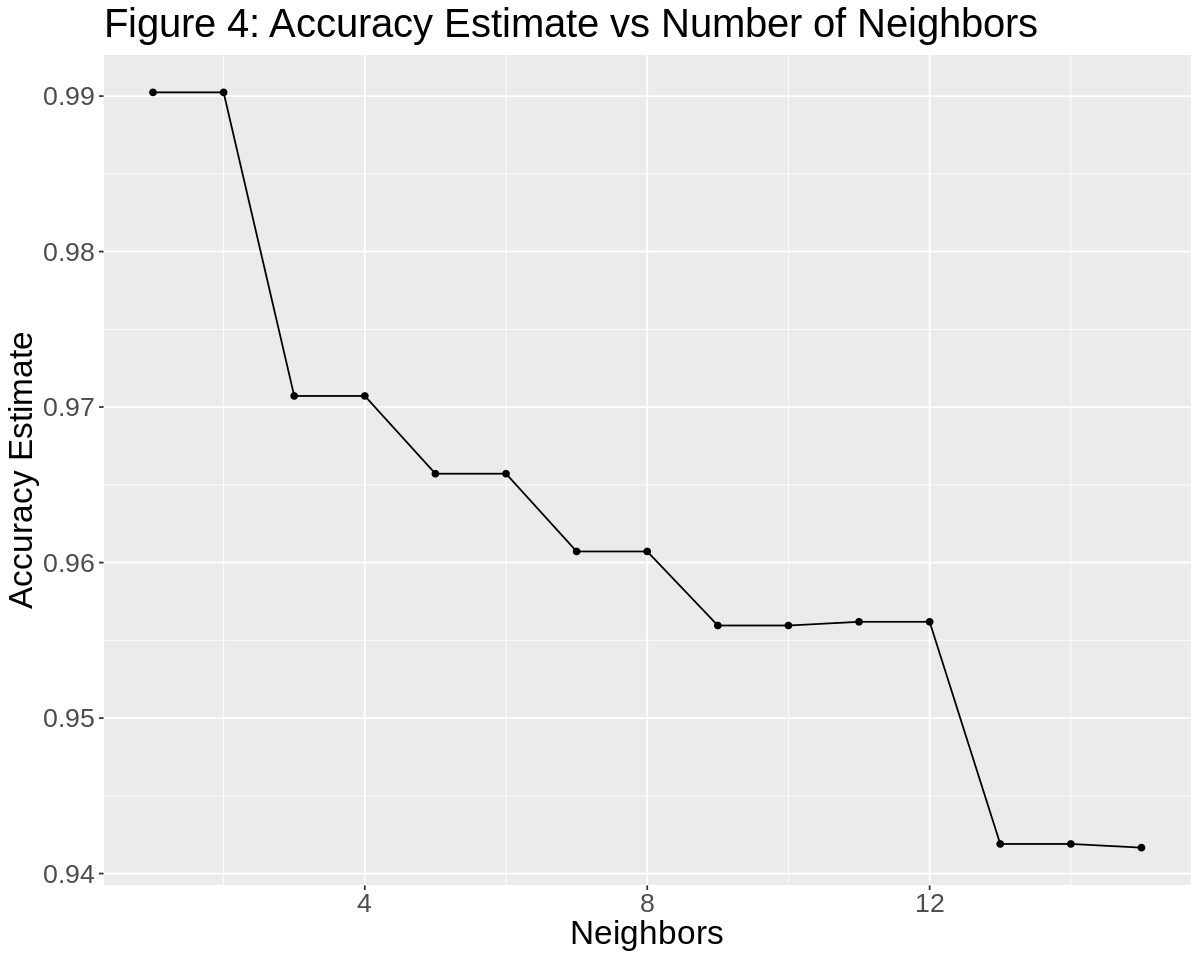

In [47]:
###
#   Cross-validation for K-NN model tuning
###

# Upsample "not fire" class in training set
fire_upsample_recipe <- recipe(Classes ~ FFMC + DC, data = fire_train) %>%
    step_upsample(Classes, over_ratio = 1, skip = FALSE) %>%
    prep()

upsampled_fire_train <- bake(fire_upsample_recipe, fire_train)

# Create recipe for data pre-processing from training dataset
fire_recipe <- recipe(Classes ~ FFMC + DC, data = upsampled_fire_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# Create 5 fold splits of training data
fire_vfold <- vfold_cv(upsampled_fire_train, v = 5, strata = Classes)

# Define K-NN model specification for K tuning
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Perform cross-validation with 15 values of K
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

knn_results_tune <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec_tune) %>%
    tune_grid(resamples = fire_vfold, grid = k_vals) %>%
    collect_metrics()

# Plot accuracy vs K 
accuracy_vs_k <- knn_results_tune %>%
    filter(.metric == "accuracy") %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        ggtitle("Figure 4: Accuracy Estimate vs Number of Neighbors") +
        theme(text = element_text(size = 20))
accuracy_vs_k

### Explanation for choosing the best k
In this step, we performed a cross-validation with five folds on 15 candidates of k value (from 1 to 15). Figure 4 shows how the accuracy varies with each k value. Based on the plot, we decided the best k value to be 10 because it has a fairly high accuracy, and changing the value to a nearby one does not decrease accuracy too much. k = 10 is also within the computational limit.

In [48]:
###
#   Train K-NN model with K = 10
###

# Re-define K-NN model specification with  K = 10
tuned_k = 10

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tuned_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Train model with training set
fire_knn_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_spec) %>%
    fit(upsampled_fire_train)

### Explanation for retraining model
Now we have decided k to be 10, we retrained our model with this tuned k value and then fit the model to our training dataset again. This will be the final model whose accuracy we want to evaluate.

In [49]:
###
#   Evaluate accuracy of model
###

# Predict labels in testing set
fire_test_predictions <- predict(fire_knn_fit, fire_test) %>%
    bind_cols(fire_test)

# Report accuracy and confusion matrix of predictions
fire_accuracy <- fire_test_predictions %>%
    metrics(truth = Classes, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()

fire_conf_mat <- fire_test_predictions %>%
    conf_mat(truth = Classes, estimate = .pred_class)

In [50]:
fire_accuracy

[1] 0.9666667

In [51]:
fire_conf_mat

          Truth
Prediction fire not fire
  fire       33        1
  not fire    1       25

Table 3: Confusion matrix for the classifier

### Explanation for evaluating the model
We use the retrained model to make predictions on our testing dataset, and the accuracy is about 97% which is fairly high. The confusion matrix showed that 1 case in each class was incorrectly predicted.

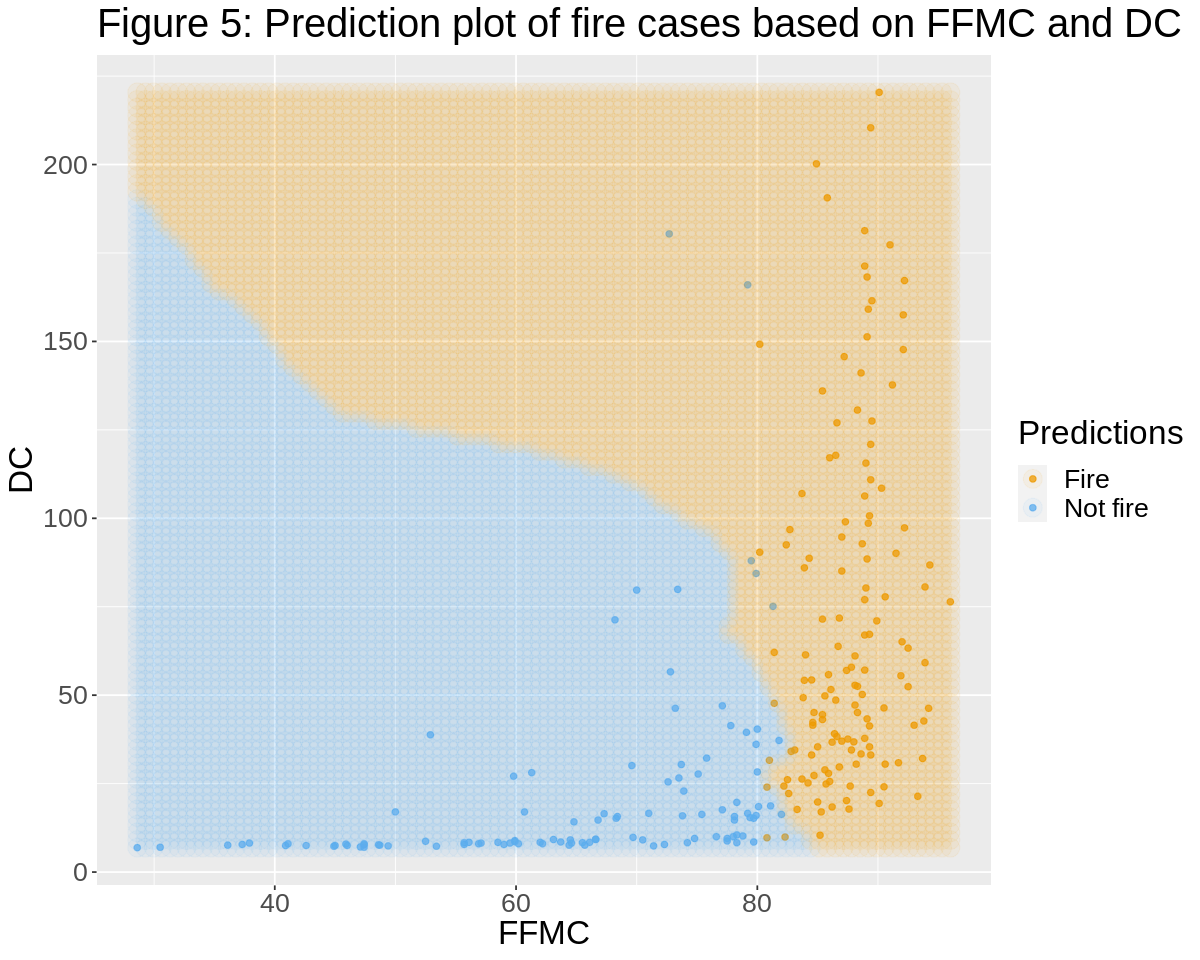

In [52]:
###
#   Create a final visualization of the prediction map based on FFMC and DC
###

# Create the grid of FFMC/DC vals, and arrange in a data frame
are_grid <- seq(min(fire_data$FFMC), max(fire_data$FFMC), length.out = 100)
smo_grid <- seq(min(fire_data$DC), max(fire_data$DC), length.out = 100)
asgrid <- as_tibble(expand.grid(FFMC = are_grid, DC = smo_grid))

# Use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(fire_knn_fit, asgrid)

# Bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(Classes = .pred_class)

# Plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = fire_data, mapping = aes(x = FFMC, y = DC, color = Classes), alpha = 0.75) +
  geom_point(data = prediction_table, mapping = aes(x = FFMC, y = DC, color = Classes), alpha = 0.06, size = 5.) +
  labs(color = "Predictions") +
  scale_color_manual(labels = c("Fire", "Not fire"), values = c("orange2", "steelblue2")) +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 5: Prediction plot of fire cases based on FFMC and DC")

wkflw_plot

### Explanation for the final visualization
Lastly, we created a prediction map using shaded area to indicate how our final model will predict fire or not fire based on the observations in the entire dataset.

## Discussion
The expected outcome is the accuracy of our classification on either “fire” or “no fire” based on two predictors from the original dataset, which we found to be 97% using FFMC and DC; but since we are using a relatively small dataset (243 observations), this accuracy may change when applied to a larger dataset. In general, our knn classification model with k = 10 does not seem to have overfit or underfit issues according to Figure 5, which suggests that it may also work well for future observations.

This outcome will be significant because the local government can take necessary measures to minimize loss if there is going to be a fire; they can warn the residents in advance if the prediction is "fire", and they can avoid unnecessary measures and panics if the prediction is "not fire". 

This finding will lead to some future questions such as how to minimize the spread if there is a fire, and to make more accurate predictions based on what the temperature, humidity, rain, and wind is like.

## Citation 

1. 
Faroudja ABID et al, Algerian Forest Fires Dataset Data Set. UCI machine Learning Repository: Algerian forest Fires dataset data set. (n.d.). Retrieved from https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++. 


2. Canada, N. R. (n.d.). Canadian wildland fire Information System: Canadian forest Fire Weather Index (fwi) system. Canadian Wildland Fire Information System | Canadian Forest Fire Weather Index (FWI) System. Retrieved from https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi. 


